In [2]:
from datetime import datetime
import random
import numpy as np 
import networkx as nx 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.sparse import csr_matrix
from numpy.linalg import norm
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
def sbm_gender_homophily_adj_and_metadata(n_g1, n_g2, p_in, p_out, seed):
    np.random.seed(seed)
    sizes = [n_g1, n_g2]
    probs = [[p_in, p_out], [p_out, p_in]]
    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    adj_matrix = nx.to_numpy_array(G)
    metadata = np.zeros((n_g1 + n_g2, 7))
    metadata[:n_g1, 1] = 1  # First block: gender 1
    metadata[n_g1:, 1] = 2  # Second block: gender 2
    return adj_matrix, metadata

In [4]:
def create_iid_core_fringe_graph(adj_matrix, k, seed=None, ff=False):
    """
    Creates a core-fringe graph using an IID sample of size k as the core.
    The fringe consists of all nodes connected to the core.
    
    Parameters:
      - adj_matrix (scipy.sparse matrix): full graph adjacency matrix.
      - k (int): number of core nodes to sample.
      - seed (int, optional): random seed.
      
    Returns:
      (core_fringe_adj, core_indices, fringe_indices)
    """
    if seed is not None:
        np.random.seed(seed)
    
    core_indices = np.random.choice(adj_matrix.shape[0], size=k, replace=False)
    is_core = np.zeros(adj_matrix.shape[0], dtype=bool)
    is_core[core_indices] = True

    A = csr_matrix(adj_matrix)
    total_edges_original = int(A.nnz / 2)
    print(f"Total edges in original adjacency: {total_edges_original}")
    neighbors = A[core_indices].nonzero()[1]
    fringe_indices = np.setdiff1d(np.unique(neighbors), core_indices)
    
    fringe_frignge_adj = A[fringe_indices, :][:, fringe_indices]
    # Build a mask that keeps only core-core and core-fringe edges.
    # Create sparse mask matrix
    mask_data = []
    mask_rows = []
    mask_cols = []
    
    # Add core-core edges
    core_core_edges = A[core_indices][:, core_indices]
    for i, j in zip(*np.triu_indices_from(core_core_edges, k=1)):
        mask_rows.extend([core_indices[i], core_indices[j]])
        mask_cols.extend([core_indices[j], core_indices[i]])
        mask_data.extend([1, 1])
    
    # Add core-fringe edges
    core_fringe_edges = A[core_indices][:, fringe_indices]
    for i, j in zip(core_fringe_edges.nonzero()[0], core_fringe_edges.nonzero()[1]):
        mask_rows.extend([core_indices[i], fringe_indices[j]])
        mask_cols.extend([fringe_indices[j], core_indices[i]])
        mask_data.extend([1, 1])

    # Create sparse mask matrix
    mask = csr_matrix((mask_data, (mask_rows, mask_cols)), shape=A.shape)

    core_fringe_adj = A.multiply(mask)

    print(f"IID core")
    print(f"Core size: {len(core_indices)}")
    core_core_edges = int(np.sum(core_fringe_adj[core_indices][:, core_indices]) / 2)
    core_fringe_edges = int(np.sum(core_fringe_adj[core_indices][:, fringe_indices]) / 2)
    print(f"Number of core-core edges: {core_core_edges}")
    print(f"Number of core-fringe edges: {core_fringe_edges}")
    
    # Calculate number of fringe-fringe edges lost
    fringe_fringe_edges = total_edges_original - (core_core_edges + core_fringe_edges)
    print(f"Number of fringe-fringe edges (lost): {fringe_fringe_edges}")

    # After constructing core_fringe_adj
    fringe_adj = core_fringe_adj[fringe_indices, :][:, fringe_indices]
    assert fringe_adj.nnz == 0, "Fringe-fringe edges exist in the core-fringe adjacency matrix!"

    if ff:
        return core_fringe_adj, core_indices, fringe_indices, fringe_frignge_adj
    else:
        return core_fringe_adj, core_indices, fringe_indices

In [6]:
def fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=0.5):
    A = adj_matrix.toarray() if hasattr(adj_matrix, 'toarray') else np.array(adj_matrix)
    A_pred = A.astype(float).copy()
    # go over all pairs of fringe-fringe and compute the jaccard sim of their adj_list
    # and if above threshold add an edge between the nodes and return this A_pred
    neighbor_set = {}
    for node in fringe_indices:
        neighbor_set[node] = set(np.nonzero(A[node])[0])

    L = len(fringe_indices)
    added_edges = 0
    for i in range(L):
        u = fringe_indices[i]
        for j in range(i+1, L):
            v = fringe_indices[j]

            neighbors_u = neighbor_set[u]
            neighbors_v = neighbor_set[v]

            union_size = len(neighbors_u | neighbors_v)
            if union_size == 0:
                sim = 0.0
            else:
                sim = len(neighbors_u & neighbors_v) / union_size 

            if sim >= threshold:
                A_pred[u,v] = 1.0
                A_pred[v,u] = 1.0
                added_edges += 1
    print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")
    return A_pred, added_edges

In [7]:
def auc_confidence_interval(y_true, y_scores, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # skip if only one class in the sample
            continue
        score = roc_auc_score(y_true[indices], y_scores[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

In [8]:
def logistic_regression_model(
    adj_matrix, core_indices, 
    fringe_indices, metadata, 
    feature='link', lr_kwargs=None, 
    seed=None, threshold=0.5,
    ff_imputation=False
):
    gender = metadata[:, 1].astype(int)  # Convert to integer
    dorm = metadata[:, 4]
    added_edges = 0
    if ff_imputation:
        # impute the fringe-fringe edges 
        ff_imputed_adj_matrix, added_edges = fill_fringe_fringe_jaccard(adj_matrix, fringe_indices, threshold=threshold)
    else:
        ff_imputed_adj_matrix = adj_matrix
    if feature == 'link':
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'triangles':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
    elif feature == 'node2vec':
        # @toDo: implement this
        X_train = ff_imputed_adj_matrix[core_indices, :]
        y_train = gender[core_indices]
        X_test = ff_imputed_adj_matrix[fringe_indices, :]
        
    print("\n Feature Space (Core-Fringe)")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    y_test = gender[fringe_indices]
    unique_train_classes = np.unique(y_train)
    print(f"Unique training classes: {unique_train_classes}")
    model = LogisticRegression(**lr_kwargs, random_state=seed)
    model.fit(X_train, y_train)
    beta = model.coef_.flatten()
    # print(f"\nModel Analysis:")
    # print(f"Number of non-zero coefficients: {np.count_nonzero(beta)}")
    # print(f"Mean absolute coefficient: {np.mean(np.abs(beta)):.4f}")
    # print(f"Max coefficient: {np.max(np.abs(beta)):.4f}")
    # print(f"Min coefficient: {np.min(np.abs(beta)):.4f}")
    # print(f"Max coefficient (No-Abs): {np.max(beta):.4f}")
    # print(f"Min coefficient (No-Abs): {np.min(beta):.4f}")

    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)
    
    # Verify class order and AUC calculation
    print("\nClass Order Verification:")
    print(f"Model classes_: {model.classes_}")  # Order of classes in the model
    print(f"Unique test classes: {np.unique(y_test)}")  # Classes in test set
    print(f"Class distribution in test: {dict(Counter(y_test))}")
    print(f"Prediction distribution: {dict(Counter(y_test_pred))}")

    # Calculate AUC for each class
    for i, class_label in enumerate(model.classes_):
        class_auc = roc_auc_score(y_test == class_label, y_test_scores[:, i])
        print(f"AUC for class {class_label}: {class_auc:.4f}")
    
    # Use the correct class index for AUC
    positive_class_idx = np.where(model.classes_ == 2)[0][0]  # Assuming 2 is our positive class
    auc = roc_auc_score(y_test, y_test_scores[:, positive_class_idx])
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute AUC confidence interval
    auc_lower, auc_upper = auc_confidence_interval(y_test, y_test_scores[:, positive_class_idx])
    print(f"AUC 95% CI: [{auc_lower:.3f}, {auc_upper:.3f}]")
    
    print(f"\nFinal Results:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {auc:.4f}")
    print(f"Training class distribution: {dict(Counter(y_train))}")
    print(f"Test class distribution: {dict(Counter(y_test))}")

    return beta, accuracy, auc, (auc_lower, auc_upper), added_edges
    

In [9]:
seed = random.seed(datetime.now().timestamp())
sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(200, 200, 0.15, 0.1, seed=seed)
print(sbm_adj_matrix.shape)
print(metadata.shape)
print(metadata[:, 1].shape)
adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(sbm_adj_matrix, 300, seed=seed, ff=True)
print(adj_matrix.shape)
print(len(core_indices))
print(len(fringe_indices))
lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
_, acc, auc, auc_ci, added_edges = logistic_regression_model(adj_matrix, core_indices, fringe_indices, 
                                                metadata, feature='link', lr_kwargs=lr_kwargs, 
                                                seed=seed, threshold=0.10, ff_imputation=True)
L = len(fringe_indices)
print(f"Possible FF Edges: {L * (L-1)} \t Added Edges : {added_edges * 2}")

(400, 400)
(400, 7)
(400,)
Total edges in original adjacency: 9972
IID core
Core size: 300
Number of core-core edges: 5477
Number of core-fringe edges: 1916
Number of fringe-fringe edges (lost): 2579
(400, 400)
300
100
Possible FF Edges: 9900 	 Added Edges : 1398

 Feature Space (Core-Fringe)
X_train shape: (300, 400)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 40, 2: 60}
Prediction distribution: {1: 41, 2: 59}
AUC for class 1: 0.9246
AUC for class 2: 0.9246
AUC 95% CI: [0.868, 0.969]

Final Results:
Test Accuracy: 0.8300
Test ROC AUC: 0.9246
Training class distribution: {2: 140, 1: 160}
Test class distribution: {1: 40, 2: 60}
Possible FF Edges: 9900 	 Added Edges : 1398


In [10]:
def jaccard_threshold_sweep():
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )

    # Core–fringe baseline
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
        adj_matrix, core_indices, fringe_indices,
        metadata, feature='link', lr_kwargs=lr_kwargs,
        seed=seed, threshold=0.10, ff_imputation=False
    )

    # Sweep thresholds
    thresholds = np.linspace(0.0, 0.9, 10)
    sweep_aucs = []
    sweep_cis = []
    sweep_added = []

    for thresh in thresholds:
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=thresh, ff_imputation=True
        )
        sweep_aucs.append(auc)
        sweep_cis.append(auc_ci)
        sweep_added.append(added_edges)

    # Prepare error bars for sweep
    lowers = [auc - ci[0] for auc, ci in zip(sweep_aucs, sweep_cis)]
    uppers = [ci[1] - auc for auc, ci in zip(sweep_aucs, sweep_cis)]

    # Prepare core–fringe arrays
    cf_aucs = np.full_like(thresholds, cf_auc, dtype=float)
    cf_lowers = np.full_like(thresholds, cf_auc - cf_ci[0], dtype=float)
    cf_uppers = np.full_like(thresholds, cf_ci[1] - cf_auc, dtype=float)

    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    plt.errorbar(
        thresholds, sweep_aucs,
        yerr=[lowers, uppers],
        fmt='-o', capsize=4,
        label='Jaccard-imputed (95% CI)'
    )

    # Core–fringe baseline as horizontal band
    plt.plot(
        thresholds, cf_aucs,
        '--', linewidth=2,
        label='Core–Fringe baseline'
    )
    plt.fill_between(
        thresholds,
        cf_aucs - cf_lowers,
        cf_aucs + cf_uppers,
        alpha=0.2
    )

    plt.xlabel("Jaccard Threshold")
    plt.ylabel("ROC AUC")
    plt.title("Link Prediction AUC: Sweep vs. Core–Fringe Baseline")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'thresholds': thresholds,
        'sweep_aucs': sweep_aucs,
        'sweep_cis': sweep_cis,
        'sweep_added': sweep_added,
        'cf_auc': cf_auc,
        'cf_ci': cf_ci,
        'cf_added_edges': cf_added
    }

Total edges in original adjacency: 62526
IID core
Core size: 300
Number of core-core edges: 5607
Number of core-fringe edges: 13106
Number of fringe-fringe edges (lost): 43813

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 343, 2: 357}
Prediction distribution: {1: 376, 2: 324}
AUC for class 1: 0.9107
AUC for class 2: 0.9107
AUC 95% CI: [0.888, 0.932]

Final Results:
Test Accuracy: 0.8214
Test ROC AUC: 0.9107
Training class distribution: {2: 143, 1: 157}
Test class distribution: {1: 343, 2: 357}
Possible FF Edges: 489300 	 Added Edges : 489300

 Feature Space (Core-Fringe)
X_train shape: (300, 1000)
y_train shape: (300,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 343, 2: 357}
Prediction distribution: {1: 315, 2: 385}
AUC for

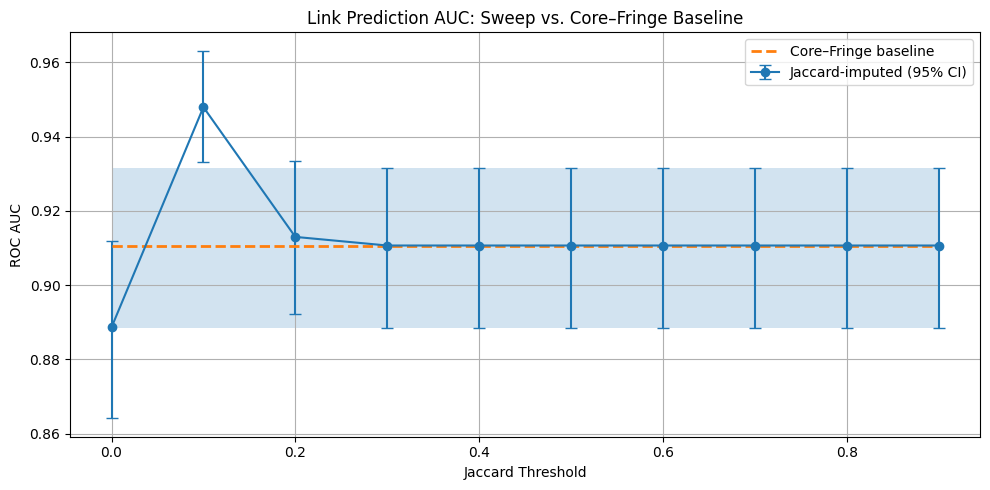

{'thresholds': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'sweep_aucs': [0.8886248376901782,
  0.9479465255489953,
  0.9129937689361459,
  0.9106744738711811,
  0.9106744738711811,
  0.9106744738711811,
  0.9106744738711811,
  0.9106744738711811,
  0.9106744738711811,
  0.9106744738711811],
 'sweep_cis': [(0.8641219994908476, 0.9118135894349879),
  (0.9331991754196525, 0.9631410256410257),
  (0.8921611122469844, 0.9334427246603971),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028),
  (0.888446901348381, 0.9316467476489028)],
 'sweep_added': [244650, 34439, 44, 0, 0, 0, 0, 0, 0, 0],
 'cf_auc': 0.9106744738711811,
 'cf_ci': (0.888446901348381, 0.9316467476489028),
 'cf_added_edges': 0}

In [10]:
jaccard_threshold_sweep()

In [13]:
def percentage_sweep():
    percentages = np.linspace(0.1, 1.0, 10)
    # Seed and generate SBM with gender homophily
    seed = random.seed(datetime.now().timestamp())
    sbm_adj_matrix, metadata = sbm_gender_homophily_adj_and_metadata(
        500, 500, 0.15, 0.1, seed=seed
    )

    # Build core-fringe split
    adj_matrix, core_indices, fringe_indices, ff_true = create_iid_core_fringe_graph(
        sbm_adj_matrix, 300, seed=seed, ff=True
    )
    aucs = {'core-fringe' : [], 'jaccard_ff_imputation' : []}
    auc_cis = {'core-fringe' : [], 'jaccard_ff_imputation' : []}
    lr_kwargs = {'C': 100, 'solver': 'liblinear', 'max_iter': 1000}
    for p in percentages:
        labelled_core_indices = np.random.choice(core_indices, size=int(p * len(core_indices)), replace=False)
        _, _, cf_auc, cf_ci, cf_added = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=1.0, ff_imputation=False
        )
        _, _, auc, auc_ci, added_edges = logistic_regression_model(
            adj_matrix, labelled_core_indices, fringe_indices,
            metadata, feature='link', lr_kwargs=lr_kwargs,
            seed=seed, threshold=0.1, ff_imputation=True
        )
        aucs['core-fringe'].append(cf_auc)
        aucs['jaccard_ff_imputation'].append(auc)
        auc_cis['core-fringe'].append(cf_ci)
        auc_cis['jaccard_ff_imputation'].append(auc_ci)
    
    
    # Prepare error bars for sweep
    lowers = {}
    uppers = {}
    for key in aucs:
        lowers[key] = [auc - ci[0] for auc, ci in zip(aucs[key], auc_cis[key])]
        uppers[key] = [ci[1] - auc for auc, ci in zip(aucs[key], auc_cis[key])]

    
    # Plot
    plt.figure(figsize=(10, 5))

    # Jaccard sweep with error bars
    for key in aucs:
        
        plt.errorbar(
            percentages, aucs[key],
            yerr=[lowers[key], uppers[key]],
            fmt='-o', capsize=4,
            label='Jaccard-imputed (95% CI)'
        )
        
    plt.xlabel("Percent Labelled Core")
    plt.ylabel("ROC AUC")
    plt.title("Core-Fringe vs Jaccard FF Imputation (Labelled Percentage Sweeep)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

Total edges in original adjacency: 62600
IID core
Core size: 300
Number of core-core edges: 5502
Number of core-fringe edges: 13143
Number of fringe-fringe edges (lost): 43955

 Feature Space (Core-Fringe)
X_train shape: (30, 1000)
y_train shape: (30,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 355, 2: 345}
Prediction distribution: {2: 409, 1: 291}
AUC for class 1: 0.7079
AUC for class 2: 0.7079
AUC 95% CI: [0.667, 0.746]

Final Results:
Test Accuracy: 0.6314
Test ROC AUC: 0.7079
Training class distribution: {2: 15, 1: 15}
Test class distribution: {1: 355, 2: 345}
Possible FF Edges: 489300 	 Added Edges : 69454

 Feature Space (Core-Fringe)
X_train shape: (30, 1000)
y_train shape: (30,)
Unique training classes: [1 2]

Class Order Verification:
Model classes_: [1 2]
Unique test classes: [1 2]
Class distribution in test: {1: 355, 2: 345}
Prediction distribution: {1: 343, 2: 357}
AUC for class 

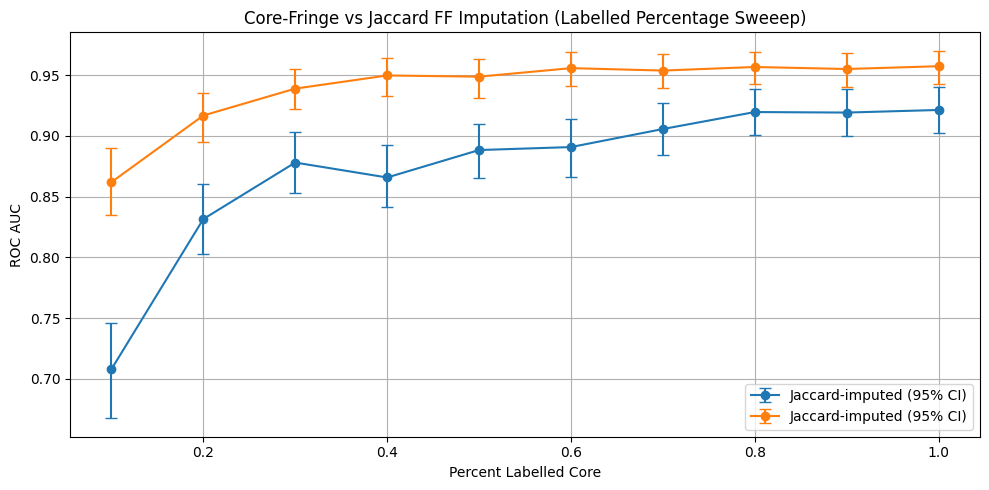

In [14]:
percentage_sweep()